In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from atlasify import atlasify

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras
import tensorflow
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

# Local import
import layers

pd.options.mode.chained_assignment = None
import matplotlib
from sklearn import metrics
from scipy.spatial import distance

# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping

print(keras.__version__)
print(tensorflow.__version__)

2023-05-18 13:04:13.963831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Eager exc False
tensorflow: 2.10.0
2.10.0
2.10.0


### Defining useful functions

In [2]:
def classifier(num_feat):
    # Inputs
    i = Input(shape = (num_feat,))
    
    # Hidden layers
    x1 = Dense(48, activation = "relu")(i)      
    x2 = Dense(32, activation = "relu")(x1)     
    x3 = Dense(16, activation = "relu")(x2)      
    
    # Output layer
    o = Dense(1, activation = "sigmoid")(x3)
    
    # Build NN classifier
    return Model(inputs = i, outputs = o, name = "classifier")


def adversary(num_gmm):
    # Inputs
    i = Input(shape = (1,))
    myy = Input(shape = (1,))
    
    # Hidden layers
    x1 = Dense(200, activation = "relu")(i)       
    x2 = Dense(100, activation = "relu")(x1)      
    x3 = Dense(50, activation = "relu")(x2)      
    
    # Gaussian mixture model (GMM) components
    coeffs = Dense(num_gmm, activation="softmax")(x3)  # GMM coefficients sum to one
    means  = Dense(num_gmm, activation="sigmoid")(x3)  # Means are on [0, 1]
    widths = Dense(num_gmm, activation="softplus")(x3)  # Widths are positive
    
    # Posterior probability distribution function
    pdf = layers.PosteriorLayer(num_gmm)([coeffs, means, widths, myy])

    return Model(inputs = [i, myy], outputs = pdf, name = "adversary")


def combined(clf, adv, lambda_reg, lr_ratio):
    # Inputs
    clf_input = Input(shape = clf.layers[0].input_shape[0][1])
    myy_input = Input(shape = (1,))
    
    # Classifier ouput
    clf_output = clf(clf_input)
    
    # Gradient reversal
    gradient_reversal = layers.GradientReversalLayer(lambda_reg * lr_ratio)(clf_output)
    
    # Adversary
    adv_output = adv([gradient_reversal, myy_input])
    
    return Model(inputs=[clf_input, myy_input], outputs=[clf_output, adv_output], name="combined")


def custom_loss(y_true, y_pred):
    """
    Kullback-Leibler loss; maximises posterior p.d.f.
    Equivalent to binary-cross-entropy for all y = 1
    """    
    return -K.log(y_pred)


np.random.seed(1)

In [1]:
# Plot the discriminant score for signal and background
def plot_dscore(d_score,ax):
    bins = np.linspace(0,1,40)
    labels = ["non. res.","VBF"]
    for signal in [0,1]:
        mask = y_test == signal
        non_zero = np.count_nonzero(~np.isnan(d_score[mask]))
        weights = np.ones_like(d_score[mask])/float(non_zero)
        ax.hist(d_score[mask],alpha=0.5, label=labels[signal],bins = bins,weights=weights)
    ax.set_xlabel("Discriminant score")
    ax.set_ylabel("Fraction")
    ax.legend()
    #plt.savefig("discriminant_distribution_VBF_vs_non_res(m_yy_less5%,pt_y1,pt_y2).pdf")
    #plt.show()

In [4]:
# Plot the ROC curve as given d-score
def plot_ROC(d_score,ax):
    effs=[]
    bins = np.linspace(0,1,50)
    back = d_score[y_test==0]
    sig = d_score[y_test==1]
    for dist in [back,sig]:
            # Normalise distributions
            non_zero = np.count_nonzero(~np.isnan(dist))
            weights = np.ones_like(dist)/float(non_zero)
            # Calculate signal and background efficiencies
            frac = np.histogram(dist,bins=bins,weights=weights)[0]
            eff = 1-np.append(0,np.cumsum(frac))
            effs.append(eff)
    # Plot ROC curve
    ax.plot(effs[0],effs[1])
    # Calculate AUC
    auc = metrics.auc(effs[0], effs[1])
    ax.text(x=0,y=0.85,s="AUC= "+"{:.4f}".format(round(auc, 4)))
    ax.plot([0,1], [0,1], linestyle='--', color='red')
    ax.set_xlabel("Background efficiency")
    ax.set_ylabel("Signal efficiency")
    ax.legend(["non res. bkg","VBF","Random classifier"])
#plt.show()

In [5]:
# Calculate the area under ROC curve
def ROC_AUC(d_score):
    effs=[]
    bins = np.linspace(0,1,50)
    back = d_score[y_test==0]
    sig = d_score[y_test==1]
    for dist in [back,sig]:
            # Normalise distributions
            non_zero = np.count_nonzero(~np.isnan(dist))
            weights = np.ones_like(dist)/float(non_zero)
            # Calculate signal and background efficiencies
            frac = np.histogram(dist,bins=bins,weights=weights)[0]
            eff = 1-np.append(0,np.cumsum(frac))
            effs.append(eff)
    # Calculate AUC
    auc = metrics.auc(effs[0], effs[1])

    return auc
#plt.show()

In [6]:
# Plot the d-score as a function of diphoton mass
def plot_D_score_myy(d_score,ax):
    non_res = np.histogram(myy_test[y_test==0],bins=np.linspace(105e3,160e3,80))
    bin_width = non_res[1][1]-non_res[1][0]
    bin_centres = np.linspace(non_res[1][0]+(bin_width/2),non_res[1][-1]-(bin_width/2),79)
    weighted_dist = np.histogram(myy_test[y_test==0],bins=np.linspace(105e3,160e3,80),weights=d_score[y_test==0])
    ax.hist(bin_centres,bins=non_res[1],weights=weighted_dist[0]/non_res[0])
    ax.set_title("D score values as a function of m_yy for non. res. bkg.")
    ax.set_xlabel("m_yy")
    ax.set_ylabel("D score")
    #plt.savefig("D_score_as_function_of_m_yy_non_res(m_yy_less5%,pt_y1,pt_y2).pdf")
    #plt.show()

In [8]:
# Plot an overlay of background distribution before and after selection
def plot_sculpting(d_score,cut,ax,y_scale):
    color1 = matplotlib.cm.get_cmap("Paired")(1/12)
    color2 = matplotlib.cm.get_cmap("Paired")(0/12)
    color3 = matplotlib.cm.get_cmap("Paired")(7/12)
    
    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*cut)]
    d_cut = sig_cut[-1]
    back_cut = back[d_score[y_test==0][selection]>d_cut]
    bins=np.linspace(105e3,160e3,80)
    signal = [back,back_cut,sig]
    labels = ["non. res.", "non res. at {}% sig. eff.".format(int(cut*100)),"VBF"]
    hist = ["step","bar","step"]
    # color = ["tab:blue","tab:darkgreen","tab:orange"]
    color = [color1,color2,color3]
    for signal, values in enumerate(signal):
        non_zero = np.count_nonzero(~np.isnan(values))
        weights = np.ones_like(values)/float(non_zero)
        ax.hist(values,alpha=1, label=labels[signal],bins = bins,weights=weights,histtype=hist[signal],color=color[signal],
                linewidth=2)

    ax.set_title("normalised m_yy distributions")
    ax.set_xlabel("m_yy")
    ax.set_ylabel("fraction")
    ax.set_yscale(y_scale)
    ax.legend()
#plt.savefig("m_yy_dist_D_0.5_non_res(m_yy_less5%).pdf")
#plt.show()

In [9]:
# Calculate the accuracy for the classification
def accuracy(d_score, cut):
    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*cut)]
    d_cut = sig_cut[-1]
    back_cut = back[d_score[y_test==0][selection]>d_cut]
    #print(d_cut)
    tp = d_score[d_score>d_cut][y_test[d_score>d_cut] == 1].size
    tn = d_score[d_score<d_cut][y_test[d_score<d_cut] == 0].size
    total = d_score.size
    accuracy = (tp + tn)/total
    return accuracy

In [10]:
# Calculate the Jensen-Shannon divergence for the background at a given d-score
def JSD(d_score,cut,region):
    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*cut)]
    d_cut = sig_cut[-1]
    back_cut = back[d_score[y_test==0][selection]>d_cut]
    
    dists=[back,back_cut]
    fracs=[]
    bins = np.linspace(105e3,160e3,40)
    bin_width = bins[1]-bins[0]
    bin_centres = np.linspace(bins[0]+(bin_width/2),bins[-1]-(bin_width/2),39)
    for i in dists:
        non_zero = np.count_nonzero(~np.isnan(i))
        weights = np.ones_like(i)/float(non_zero)
        frac=np.histogram(i,bins = bins,weights=weights)[0]
        fracs.append(frac)
    if region == "higgs":
        cut = (bin_centres>121e3)*(bin_centres<129e3)
        JSD_score = np.square(distance.jensenshannon(fracs[0][cut], fracs[1][cut]))
    else:
        JSD_score = np.square(distance.jensenshannon(fracs[0], fracs[1]))
    return JSD_score

In [11]:
def Dscore_fractions_ratio(d_score,cut):

    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*cut)]
    d_cut = sig_cut[-1]
    back_cut = back[d_score[y_test==0][selection]>d_cut]
    back_eff = back_cut.size/back.size
    print("Background eff. at",cut,"signal eff.= ",back_eff)
    bins=np.linspace(105e3,160e3,40)
    bin_width = bins[1]-bins[0]
    bin_centres = np.linspace(bins[0]+(bin_width/2),bins[-1]-(bin_width/2),39)
    
    dists=[back,back_cut]
    labels = ["before","after"]
    err_label = ["","stat. uncertainty"]
    fractions = []
    unscaled_dists = []
    weights_comb = []
    fig, ax = plt.subplots(2,1,figsize=(8,6), gridspec_kw={'height_ratios': [2, 1]})
    for i, values in enumerate(dists):
        non_zero = np.count_nonzero(~np.isnan(values))
        weights = np.ones_like(values)/float(non_zero)
        fraction = ax[0].hist(values, label=labels[i],bins = bins,weights=weights, histtype="step",linewidth=2)
        fractions.append(fraction[0])
        unscaled = np.histogram(values,bins=bins)
        unscaled_dists.append(unscaled[0])
        weights_comb.append(weights[0])
        ax[0].fill_between(bin_centres, fraction[0]-np.sqrt(unscaled[0])*weights[0], fraction[0]+np.sqrt(unscaled[0])*weights[0], 
                           alpha=0.8,step="mid", label=err_label[i],hatch="////",facecolor="none",linewidth=0)
    ax[0].legend()
    plt.suptitle("normalised m_yy non_res_bkg distributions before and after D cut at {}% sig. eff.".format(int(100*cut)),y=0.95)

    for i in range(2):
        ax[1].hist(bin_centres,bins=bins,weights=fractions[i]/fractions[0],histtype="step",linewidth=2)
        y_min= (fractions[i]-np.sqrt(unscaled_dists[i])*weights_comb[i])/fractions[0]
        y_max= (fractions[i]+np.sqrt(unscaled_dists[i])*weights_comb[i])/fractions[0]
        ax[1].fill_between(bin_centres, y_min, y_max, 
                               alpha=0.8,step="mid",hatch="////",facecolor="none",linewidth=0)
    ax[1].set_ylim(0.7,1.3)
    plt.setp(ax, xlim=[105e3,160e3])
    
    plt.xlabel("m_yy")
    ax[0].set_ylabel("fraction")
    ax[1].set_ylabel("ratio")
    #plt.savefig("m_yy_dist_non_res_bkgs(m_yy_less5%).pdf")
    plt.show()

In [12]:
# Calculate the background efficiency for a given d-score
def Back_eff(d_score,cut):
    selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
    back = myy_test[y_test==0][selection]
    sig = myy_test[y_test==1]
    sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*cut)]
    d_cut = sig_cut[-1]
    back_cut = back[d_score[y_test==0][selection]>d_cut]
    back_eff = back_cut.size/back.size
    #print("Back_eff= ",back_eff)
    return back_eff

## Data preprocessing

### Load 10% of pythia VBF and non. res. bkg.

Loading the engineered PYTHIA VBF and non-resonant background features (1 combined dataset)

In [13]:
features = pd.read_csv("VBF_non_res_10%total",dtype="float32")

In [14]:
features.columns

Index(['njets', 'pt_highest_pt_jet', 'sum_pt_all_jets', 'number_central_jets',
       'invariant_mass_jet_system', 'sum_trans_energy_particles',
       'delta_phi_yy_jets', 'delta_rapidity_yy_jets', 'pt_j1_j2', 'm_j1_j2',
       'delta_y_j1_j2', 'delta_phi_j1_j2', 'delta_eta_j1_j2', 'pt_yy_j1',
       'm_yy_j1', 'pt_yy_jj', 'm_yy_jj', 'eta_photon1', 'eta_photon2', 'pt_yy',
       'rapidity_yy', 'forward_jet_etas', 'm_yy_jF', 'p_H_T', 'm_yy', 'pt_y1',
       'pt_y2', 'pt_yy_thrust', 'delta_eta_yy', 'eta_zepp', 'phi_star_yy',
       'cos_theta_star_yy', 'signal'],
      dtype='object')

### Make signal cuts

Making cuts to the signal to match the background cuts

In [15]:
features.drop(features[features.njets<2].index,inplace=True)
features.drop(features[features.m_j1_j2<0.3e6].index,inplace=True)

In [16]:
features.reset_index(drop=True, inplace=True)

### Select all features except for m_yy

In [17]:
non_res_bkg = features[features.signal==0]

In [18]:
print("Number of features with less 5% corr. for bkg:",\
      non_res_bkg.columns[abs(non_res_bkg.corrwith(features["m_yy"]))<0.05].shape[0])

Number of features with less 5% corr. for bkg: 12


In [19]:
print("Number of features with less 10% corr. for bkg:",\
non_res_bkg.columns[abs(non_res_bkg.corrwith(features["m_yy"]))<0.10].shape[0])

Number of features with less 10% corr. for bkg: 19


In [20]:
print("Number of features with less 15% corr. for bkg:",\
non_res_bkg.columns[non_res_bkg.corrwith(features["m_yy"])<0.15].shape[0])

Number of features with less 15% corr. for bkg: 22


In [21]:
print("Number of features with less 20% corr. for bkg:",\
non_res_bkg.columns[non_res_bkg.corrwith(features["m_yy"])<0.20].shape[0])

Number of features with less 20% corr. for bkg: 28


In [22]:
print("Number of features with less 35% corr. for bkg:",\
non_res_bkg.columns[non_res_bkg.corrwith(features["m_yy"])<0.35].shape[0])

Number of features with less 35% corr. for bkg: 31


In [23]:
#selection = non_res_bkg.columns[non_res_bkg.corrwith(features["m_yy"])<0.05]

The correlation for all features with $m_{\gamma \gamma}$

In [24]:
non_res_bkg.corrwith(features["m_yy"]).sort_values()

delta_eta_j1_j2              -0.083124
delta_y_j1_j2                -0.082942
phi_star_yy                  -0.010001
delta_rapidity_yy_jets       -0.003953
delta_phi_j1_j2              -0.001753
forward_jet_etas             -0.000775
rapidity_yy                   0.000766
eta_photon2                   0.001611
eta_photon1                   0.002236
eta_zepp                      0.003042
m_j1_j2                       0.018897
delta_phi_yy_jets             0.020330
invariant_mass_jet_system     0.039217
njets                         0.049167
number_central_jets           0.065590
pt_yy_j1                      0.071606
pt_yy_jj                      0.080158
cos_theta_star_yy             0.089883
sum_pt_all_jets               0.098211
pt_yy_thrust                  0.100098
pt_highest_pt_jet             0.114288
pt_j1_j2                      0.132315
m_yy_jj                       0.159044
sum_trans_energy_particles    0.179709
pt_yy                         0.179806
p_H_T                    

### Build & train combined model


Function to update the training variable selection

In [25]:
def select_var(corr):
    selection = non_res_bkg.columns[non_res_bkg.corrwith(features["m_yy"])<corr]
    features_df = features[selection]

    ### Separate features and target column
    X = features_df
    y = features["signal"]
    X.shape,y.shape
    myy = features["m_yy"].values

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test, myy_train, myy_test = train_test_split(X, y.values, myy, test_size = 0.2, random_state = 5)

    # Rescale diphoton invariant mass to [0,1]
    sc_myy_train = myy_train - myy_train.min()
    sc_myy_train /= myy_train.max()

    ### Standardize
    scalar = StandardScaler()
    scalar.fit(x_train)
    x_train = scalar.transform(x_train)
    x_test = scalar.transform(x_test)

    ### Fill missing values
    x_train = np.nan_to_num(x_train,nan=0)
    x_test = np.nan_to_num(x_test,nan=0)
    return x_train,x_test,y_train,y_test,sc_myy_train,myy_test

Function to update the ANN for different regularisation parameters

In [26]:
def ANN_reg(reg):
    # Number of samples, features, epochs & batch size
    num_samples = x_train.shape[0]
    num_feat = x_train.shape[1]
    num_epochs = 200
    batch = 5000

    lambda_reg = reg             # Regularization parameter 
    num_gmm = 5                # Number of GMM components
    lr = 1e-5                 # Relative learning rates for classifier and adversary

    loss_weights = [lr, lambda_reg]

    # Prepare sample weights (i.e. only do mass-decorrelation for background)
    sample_weight = [np.ones(num_samples, dtype=float), (y_train == 0).astype(float)]
    sample_weight[1] *= np.sum(sample_weight[0])/ np.sum(sample_weight[1])   

    # Prepare class weights
    weight = {0:1, 1:3.9,}    
    class_weight = [weight, weight]


    ## Define classifier, adversary & combined network

    clf = classifier(num_feat)
    adv = adversary(num_gmm)
    ANN = combined(clf, adv, lambda_reg, lr)
    return ANN,sample_weight,class_weight,loss_weights

The set of hyperparameters that will be tested

In [27]:
corrs = [0.05,0.1,0.2]
regs = [0.1875,0.375,0.75,1.5,3,6]

The loop to test all of the hyperparameter combinations

### Change filepath by removing ",trial6" for the generated weights to be correctly called later

In [ ]:
min_val_loss = np.array([])
# Loop over all possible combinations of chosen hyperparameter values
for corr in corrs:
    for reg in regs:
                # Select training variables
                x_train,x_test,y_train,y_test,sc_myy_train,myy_test = select_var(corr)
                # Save each model weights and stop training early if no improvement after 10 epochs
                my_callbacks = [
                    ModelCheckpoint(
                    filepath="ANN_optimization_weights\corr={},reg={},trial6.hdf5".format(corr,reg),
                    save_weights_only=True,
                    monitor="val_classifier_loss",
                    save_freq="epoch",
                    save_best_only=True,
                    mode="auto",
                    verbose=True)]

                # Set model paramters
                ANN,sample_weight,class_weight,loss_weights = ANN_reg(reg)
                
                ANN.compile(optimizer="adam", loss=["binary_crossentropy", custom_loss], loss_weights = loss_weights)

                # Configure training details
                hist_ANN = ANN.fit([x_train, sc_myy_train], [y_train, np.ones_like(sc_myy_train)], 
                   sample_weight = sample_weight, epochs = 100, batch_size = 5000, 
                   validation_split = 0.2, class_weight = class_weight, verbose = 2,callbacks=my_callbacks)
                # Save lowest val_loss of each model
                min_val_loss = np.append(min_val_loss,min(hist_ANN.history["val_classifier_loss"]))
                
np.savetxt("min_val_loss",min_val_loss)

### Carry out analysis on the hyperparameter optimisation results

In [28]:
corrs = [0.05,0.1,0.2]
regs = [0.1875,0.375,0.75,1.5,3,6]

In [ ]:
#Best model values
# corrs = [0.1]
# regs = [0.1875]

In [29]:
JSDs_incl = np.array([])
JSDs_incl_std = np.array([])
JSDs_higgs = np.array([])
JSDs_higgs_std = np.array([])
ROC_AUCs = np.array([])
back_effs = np.array([])
d_scores = []

bins = np.linspace(105e3,160e3,40)
bin_width = bins[1]-bins[0]
bin_centres = np.linspace(bins[0]+(bin_width/2),bins[-1]-(bin_width/2),39)
cut_higgs = (bin_centres>121e3)*(bin_centres<129e3)

# Loop over all possible combinations of chosen hyperparameter values
for corr in corrs:
    for reg in regs:
# for corr in [0.1]:
#     for reg in [12]:
                # Select training variables
                x_train,x_test,y_train,y_test,sc_myy_train,myy_test = select_var(corr)
                # Number of samples, features, epochs & batch size
                num_samples = x_train.shape[0]
                num_feat = x_train.shape[1]
                num_epochs = 100
                batch = 5000

                lambda_reg = reg             # Regularization parameter 
                num_gmm = 5                # Number of GMM components
                lr = 1e-5                 # Relative learning rates for classifier and adversary

                loss_weights = [lr, lambda_reg]

                # Prepare sample weights (i.e. only do mass-decorrelation for background)
                sample_weight = [np.ones(num_samples, dtype=float), (y_train == 0).astype(float)]
                sample_weight[1] *= np.sum(sample_weight[0])/ np.sum(sample_weight[1])   

                # Prepare class weights
                weight = {0:1, 1:3.9,}    
                class_weight = [weight, weight]

                ## Define classifier, adversary & combined network

                clf = classifier(num_feat)
                adv = adversary(num_gmm)
                ANN = combined(clf, adv, lambda_reg, lr)
                
                # Load the already trained weights for each model
                ANN.load_weights("ANN_optimization_weights\corr={},reg={}.hdf5".format(corr,reg))
                #clf = classifier(num_feat)
                
                d_score_ANN = clf.predict(x_test,verbose=1)
                d_score_ANN = d_score_ANN.flatten()
                
                
                
                #### Full Analysis plots ####
                #### Uncomment to display the plots ####
                
#                 fig, ax = plt.subplots(2,2, figsize=(12,8))
#                 ax = ax.flatten()
#                 plot_dscore(d_score_ANN,ax[0])
#                 plot_ROC(d_score_ANN,ax[1])
#                 plot_D_score_myy(d_score_ANN,ax[2])
#                 plot_sculpting(d_score_ANN,0.8,ax[3],"log")
#                 fig.tight_layout()


#                 Dscore_fractions_ratio(d_score_ANN,0.8)


                print("Accuracy: ",accuracy(d_score_ANN,0.8))
                print("JSD inclusive= ",JSD(d_score_ANN,0.8,"incl"))
                print("JSD higgs region= ",JSD(d_score_ANN,0.8,"higgs"))
                
                std = []
                std_higgs = []
                for trial in range(100):
                    selection = np.random.choice(myy_test[y_test==0],int(Back_eff(d_score_ANN,0.8)*myy_test[y_test==0].size))
                    before_cut = np.histogram(myy_test[y_test==0],bins=bins)[0]
                    after_cut = np.histogram(selection,bins=bins)[0]
                    # Uncertainty based on no sculpting
                    JSD_set = []
                    JSD_set_higgs = []
                    unc_incl = np.sqrt(after_cut)
                    unc_higgs = np.sqrt(after_cut[cut_higgs])
                    for i in range(100):
                        updated_fracs = []
                        updated_fracs_higgs = []
                        for i in range(unc_incl.size):
                            shift = unc_incl[i]*(np.random.uniform()-0.5)
                            updated_fracs.append(after_cut[i]+shift)
                        
                        JSD_set.append(np.square(distance.jensenshannon(before_cut, updated_fracs)))
                        
                        for i in range(unc_higgs.size):
                            shift_higgs = unc_higgs[i]*(np.random.uniform()-0.5)
                            updated_fracs_higgs.append(after_cut[cut_higgs][i]+shift_higgs)
                           
                        JSD_set_higgs.append(np.square(distance.jensenshannon(before_cut[cut_higgs], updated_fracs_higgs)))
                    
                    
                    std.append(np.percentile(np.sort(JSD_set),68)) # Uncertainty on the current result
                
                    std_higgs.append(np.percentile(np.sort(JSD_set_higgs),68)) # Uncertainty on the current result, higgs region
                
                
                JSDs_incl_std = np.append(JSDs_incl_std,np.mean(std))
                JSDs_higgs_std = np.append(JSDs_higgs_std,np.mean(std_higgs))

                JSDs_incl = np.append(JSDs_incl,JSD(d_score_ANN,0.8,"incl"))
                JSDs_higgs = np.append(JSDs_higgs,JSD(d_score_ANN,0.8,"higgs"))
                ROC_AUCs = np.append(ROC_AUCs,ROC_AUC(d_score_ANN))
                back_effs = np.append(back_effs,Back_eff(d_score_ANN,0.8))
                d_scores.append(d_score_ANN)
                

2023-05-18 13:04:27.576957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 13:04:27.584661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8372384756247027
JSD inclusive=  0.000686180079355836
JSD higgs region=  0.00028834561817348003


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8376133692846741
JSD inclusive=  0.0006255505140870808
JSD higgs region=  0.00028696912340819836


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8416506856228282
JSD inclusive=  0.0005992315127514303
JSD higgs region=  0.00027957523707300425


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8253428114140701
JSD inclusive=  0.0005563838640227914
JSD higgs region=  0.00034401798620820045


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8122503712889132
JSD inclusive=  0.0004452202701941133
JSD higgs region=  0.0001465421519242227


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8064395195593558
JSD inclusive=  0.0005103674484416842
JSD higgs region=  0.00018087239004671574


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8679364987815956
JSD inclusive=  0.0009177422034554182
JSD higgs region=  0.0005554810632020235


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.868383487376177
JSD inclusive=  0.0009775031358003616
JSD higgs region=  0.0007941231597214936


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8655141089787032
JSD inclusive=  0.0009362798882648349
JSD higgs region=  0.0003482131287455558


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8585064813346214
JSD inclusive=  0.001024810364469886
JSD higgs region=  0.0006279658991843462


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8540942713364958
JSD inclusive=  0.0008977456018328667
JSD higgs region=  0.00044275645632296806


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8510662840828803
JSD inclusive=  0.0008416965138167143
JSD higgs region=  0.00040519703179597855


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8869983994924516
JSD inclusive=  0.003876194823533297
JSD higgs region=  0.0014428994618356226


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8869551425316857
JSD inclusive=  0.00322546623647213
JSD higgs region=  0.0010310055222362278


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8842876299511196
JSD inclusive=  0.001908677746541798
JSD higgs region=  0.0010218096431344745


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8791112136461292
JSD inclusive=  0.0014006568817421794
JSD higgs region=  0.0007404366042464972


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.875823684627918
JSD inclusive=  0.0013964143581688406
JSD higgs region=  0.0007992108585312964


/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy:  0.8652401482271855
JSD inclusive=  0.0012095838319510224
JSD higgs region=  0.0005964216543361545


### Calculate the uncertainty on the benchmark result

In [30]:
std = []
std_higgs = []
JSD_set = []
JSD_set_higgs = []

for trial in range(1000):
    # Randomly select 0.1645881 fraction of the test events and check entropy between original and selected sample
    # Fraction of selected events corresponds to benchmark background efficiency 
    selection = np.random.choice(myy_test[y_test==0],int(0.1645881*myy_test[y_test==0].size))
    before_cut = np.histogram(myy_test[y_test==0],bins=bins)[0]
    after_cut = np.histogram(selection,bins=bins)[0]
    # Uncertainty based on no sculpting

    JSD_set.append(np.square(distance.jensenshannon(before_cut, after_cut)))


    JSD_set_higgs.append(np.square(distance.jensenshannon(before_cut[cut_higgs], after_cut[cut_higgs])))

In [31]:
benchmark_mean = np.mean(JSD_set)

In [32]:
benchmark_mean_higgs = np.mean(JSD_set_higgs)

In [33]:
print("Benchmark mean:",round(benchmark_mean,6))

Benchmark mean: 0.000788


In [34]:
print("Benchmark mean higgs region:",round(benchmark_mean_higgs,6))

Benchmark mean higgs region: 0.000623


Set the uncertainty in the entropy of the selected events to be equivalent to the 68th percentile

In [35]:
benchmark_std = np.percentile(np.sort(JSD_set),68)

In [36]:
benchmark_std_higgs = np.percentile(np.sort(JSD_set_higgs),68)

In [37]:
print("Benchmark standard deviation:",round(benchmark_std,6))# Uncertainty on the benchmark result

Benchmark standard deviation: 0.000855


In [38]:
print("Benchmark standard deviation higgs region:",round(benchmark_std_higgs,6))# Uncertainty on the benchmark result, higgs

Benchmark standard deviation higgs region: 0.000738


### Combined plots of hyperparameter optimisation and benchmark results

### Inclusive region

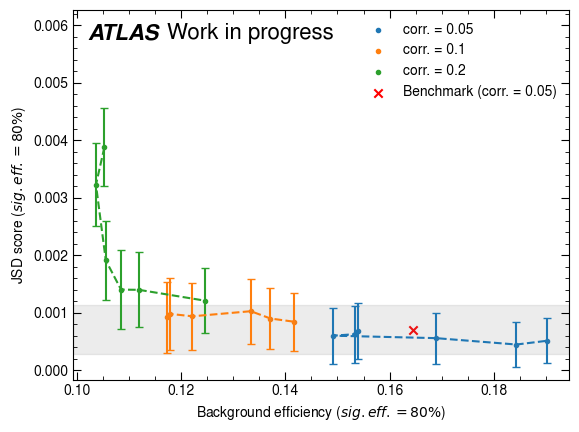

In [39]:
plt.rcParams.update({'font.size': 10})
back_effs = back_effs.reshape(3,6)
JSDs_incl = JSDs_incl.reshape(3,6)
JSDs_incl_std = JSDs_incl_std.reshape(3,6)

for i in range(3):
    #for j in range(3):
    plt.scatter(back_effs[i,:],JSDs_incl[i,:],marker=".")
    plt.errorbar(back_effs[i,:],JSDs_incl[i,:],yerr=(JSDs_incl_std[i,:]/2),linestyle="--",capsize=3)
    
plt.scatter(0.1645881,0.0007034581,marker="x",color="red")

plt.axhspan(ymin=(0.0007034581+(benchmark_std/2)),
                 ymax=(0.0007034581-(benchmark_std/2)),color="grey",alpha=0.15)
# plt.axhline(y=0.0007034581, color='r', linestyle='-')
plt.legend(["corr. = 0.05","corr. = 0.1","corr. = 0.2","Benchmark (corr. = 0.05)"],frameon=False)
plt.ylabel("JSD score ($sig. eff. = 80 \%$)")
plt.xlabel("Background efficiency ($sig. eff. =80 \%$)")
atlasify("Work in progress")
#plt.savefig("JSD vs Background_eff (incl).pdf")
#plt.legend(frameon = False)
#plt.yscale("log")
#plt.ylim([0,0.5])
#plt.xlim([0.11,0.12])
plt.show()

In [40]:
#np.savetxt("ANN score",d_score_ANN)

In [41]:
print("Benchmark std = +/-",round(benchmark_std/2,6))

Benchmark std = +/- 0.000427


### Higgs region

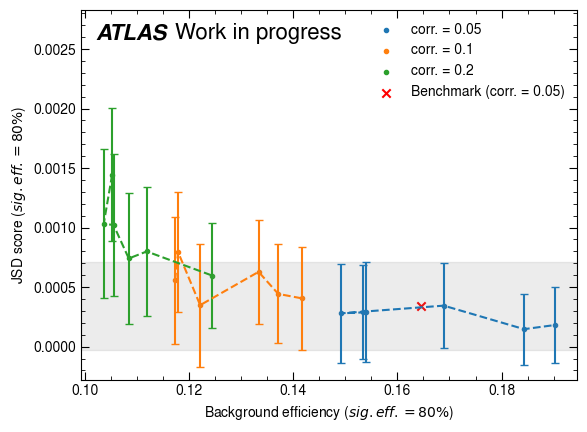

In [42]:
back_effs = back_effs.reshape(3,6)
JSDs_higgs = JSDs_higgs.reshape(3,6)
JSDs_higgs_std = JSDs_higgs_std.reshape(3,6)

for i in range(3):
    #for j in range(3):
    plt.scatter(back_effs[i,:],JSDs_higgs[i,:],marker=".")
    plt.errorbar(back_effs[i,:],JSDs_higgs[i,:],yerr=(JSDs_higgs_std[i,:]/2),linestyle="--",capsize=3)
    
plt.scatter(0.1645881,0.0003409238,marker="x",color="red")

plt.axhspan(ymin=(0.0003409238+(benchmark_std_higgs/2)),
                 ymax=(0.0003409238-(benchmark_std_higgs/2)),color="grey",alpha=0.15)
plt.legend(["corr. = 0.05","corr. = 0.1","corr. = 0.2","Benchmark (corr. = 0.05)"],frameon=False)
plt.ylabel("JSD score ($sig. eff. = 80 \%$)")
plt.xlabel("Background efficiency ($sig. eff. =80 \%$)")
atlasify("Work in progress")
#plt.savefig("JSD vs Background_eff (higgs).pdf")
#plt.yscale("log")
#plt.ylim([0,0.5])
plt.show()

In [43]:
print("Benchmark std = +/-",round(benchmark_std_higgs/2,6))

Benchmark std = +/- 0.000369


### Best model performance

In [44]:
d_score = d_scores[6]

Back_eff=  0.11735600448320166


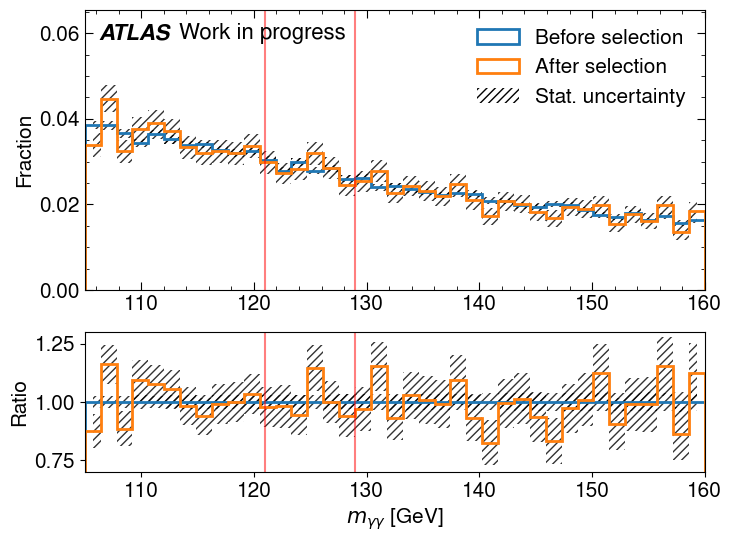

In [45]:
plt.rcParams.update({'font.size': 15})
selection = (myy_test[y_test==0]>105e3)&(myy_test[y_test==0]<160e3)
back = myy_test[y_test==0][selection]
sig = myy_test[y_test==1]
sig_cut = d_score[y_test==1][np.argsort(-d_score[y_test==1])][:int(d_score[y_test==1].shape[0]*0.8)]
d_cut = sig_cut[-1]
back_cut = back[d_score[y_test==0][selection]>d_cut]
back_eff = back_cut.size/back.size
print("Back_eff= ",back_eff)
bins=np.linspace(105e3,160e3,40)/1000
bin_width = bins[1]-bins[0]
bin_centres = np.linspace(bins[0]+(bin_width/2),bins[-1]-(bin_width/2),39)

dists=[back/1000,back_cut/1000]
labels = ["Before selection","After selection"]
err_label = ["","Stat. uncertainty"]
fractions = []
unscaled_dists = []
weights_comb = []
fig, ax = plt.subplots(2,1,figsize=(8,6), gridspec_kw={'height_ratios': [2, 1]})
for i, values in enumerate(dists):
    non_zero = np.count_nonzero(~np.isnan(values))
    weights = np.ones_like(values)/float(non_zero)
    fraction = ax[0].hist(values, label=labels[i],bins = bins,weights=weights, histtype="step",linewidth=2)
    fractions.append(fraction[0])
    unscaled = np.histogram(values,bins=bins)
    unscaled_dists.append(unscaled[0])
    weights_comb.append(weights[0])
    ax[0].fill_between(bin_centres, fraction[0]-np.sqrt(unscaled[0])*weights[0], fraction[0]+np.sqrt(unscaled[0])*weights[0], 
                       alpha=0.8,step="mid", label=err_label[i],hatch="////",facecolor="none",linewidth=0)
ax[0].legend()
#plt.suptitle("normalised m_yy non_res_bkg distributions before and after D cut at {}% sig. eff.".format(int(100*cut)),y=0.95)
ax[0].axvline(x = 121, color = "red",alpha=0.5)
ax[0].axvline(x = 129, color = "red",alpha=0.5)
atlasify("Work in progress", axes=ax[0])
for i in range(2):
    ax[1].hist(bin_centres,bins=bins,weights=fractions[i]/fractions[0],histtype="step",linewidth=2)
    y_min= (fractions[i]-np.sqrt(unscaled_dists[i])*weights_comb[i])/fractions[0]
    y_max= (fractions[i]+np.sqrt(unscaled_dists[i])*weights_comb[i])/fractions[0]
    ax[1].fill_between(bin_centres, y_min, y_max, 
                           alpha=0.8,step="mid",hatch="////",facecolor="none",linewidth=0)
ax[1].set_ylim(0.7,1.3)
plt.setp(ax, xlim=[105e3/1000,160e3/1000])

plt.xlabel("$m_{\gamma \gamma}$ [GeV]")
ax[1].axvline(x = 121, color = "red",alpha=0.5)
ax[1].axvline(x = 129, color = "red",alpha=0.5)
ax[0].set_ylabel("Fraction")
ax[1].set_ylabel("Ratio")

# plt.savefig("Background ratio plot ANN.png",dpi=300)
plt.show()

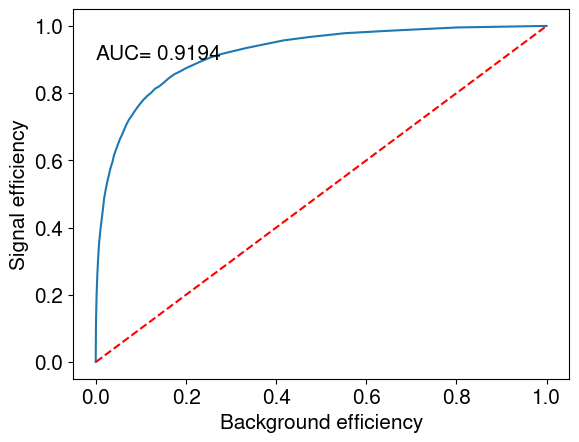

In [46]:
effs=[]
bins = np.linspace(0,1,50)
back = d_score[y_test==0]
sig = d_score[y_test==1]
for dist in [back,sig]:
        # Normalise distributions
        non_zero = np.count_nonzero(~np.isnan(dist))
        weights = np.ones_like(dist)/float(non_zero)
        # Calculate signal and background efficiencies
        frac = np.histogram(dist,bins=bins,weights=weights)[0]
        eff = 1-np.append(0,np.cumsum(frac))
        effs.append(eff)
# Plot ROC curve
plt.plot(effs[0],effs[1])
# Calculate AUC
auc = metrics.auc(effs[0], effs[1])
plt.text(x=0,y=0.9,s="AUC= "+"{:.4f}".format(round(auc, 4)))
plt.plot([0,1], [0,1], linestyle='--', color='red')
plt.xlabel("Background efficiency")
plt.ylabel("Signal efficiency")
#plt.legend(["non res. bkg","VBF","Random classifier"])
plt.show()